In [4]:
# August 25 2017
# This file is for experiments with student2 4 skills and training trajectory length 5
# to check different architectures and whether they can learn good models
# This uses student2a where transitions happen after observations

%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import scipy as sp
import six
import pickle
from matplotlib.pyplot import *

def ixs2ranks(ixs):
    ranks = np.zeros(ixs.shape,dtype=np.int)
    for r,i in enumerate(ixs):
        ranks[i] = r
    return ranks

def graph_trainauc_score(vloss, scores):
    figure()
    xs = np.sum(vloss,axis=1)
    ys = scores
    title('Training Loss AUC versus Actual Performance')
    xlabel('Training Loss AUC')
    ylabel('Posttest Score')
    plot(xs,ys,'.')
    ylim(0,1)

def graph_trainauc_qval(vloss, qval):
    figure()
    xs = np.sum(vloss,axis=1)
    ys = qval
    title('Training Loss AUC versus Own Qvalue')
    xlabel('Training Loss AUC')
    ylabel('Qvalue')
    plot(xs,ys,'.')

def graph_qval_score(qval, scores):
    figure()
    xs = qval
    ys = scores
    title('Own Qval versus Actual Performance')
    xlabel('Qvalue')
    ylabel('Posttest Score')
    plot(xs,ys,'.')

def graph_ensemble(fsen_sq, fsen_sim_sq):
    figure()
    title('Ensemble Size versus Actual Performance')
    xs = np.array(list(six.moves.range(len(fsen_sq))))*5+5
    ys = fsen_sim_sq
    xlabel('# of models in ensemble')
    ylabel('Posttest Score')
    plot(xs, ys, '.')
    ylim(-0.1,1.1)
    figure()
    title('Ensemble Size versus Own Qvalue')
    xs = np.array(list(six.moves.range(len(fsen_sq))))*5+5
    ys = fsen_sq
    xlabel('# of models in ensemble')
    ylabel('Qvalue')
    plot(xs, ys, '.')
    ylim(-0.1,1.1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Learning Rate 0.0005 Stability

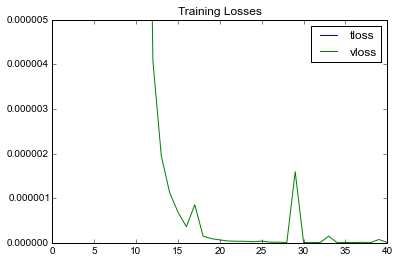

In [7]:
data11 = np.load('experiments/test2_modelgrusimple_mid-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runA.npz')

tloss = data11['tloss']
tloss_mean = np.mean(tloss,axis=0)
tloss_std = np.std(tloss,axis=0)/tloss.shape[0]

vloss = data11['vloss']
vloss_mean = np.mean(vloss,axis=0)
vloss_std = np.std(vloss,axis=0)/vloss.shape[0]

figure()
title('Training Losses')
plot(tloss_mean,label='tloss')
plot(vloss_mean,label='vloss')
ylim(0,0.000005)
legend()
# looks like after 20 is enough. Use 25.

# Learning Rate 0.0005 Noise 0.05 Stability

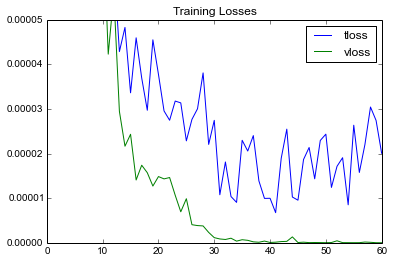

In [8]:
data11 = np.load('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runA.npz')

tloss = data11['tloss']
tloss_mean = np.mean(tloss,axis=0)
tloss_std = np.std(tloss,axis=0)/tloss.shape[0]

vloss = data11['vloss']
vloss_mean = np.mean(vloss,axis=0)
vloss_std = np.std(vloss,axis=0)/vloss.shape[0]

figure()
title('Training Losses')
plot(tloss_mean,label='tloss')
plot(vloss_mean,label='vloss')
ylim(0,0.00005)
legend()
# looks like around 50

# Learning Rate 0.0005 Output Dropout 0.5 Stability

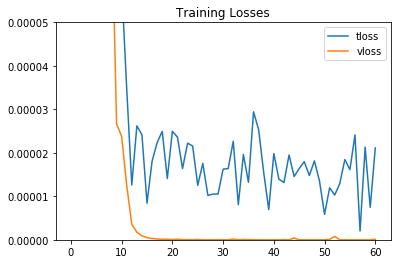

In [2]:
data11 = np.load('experiments/test2_modelgrusimple_mid-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runA.npz')

tloss = data11['tloss']
tloss_mean = np.mean(tloss,axis=0)
tloss_std = np.std(tloss,axis=0)/tloss.shape[0]

vloss = data11['vloss']
vloss_mean = np.mean(vloss,axis=0)
vloss_std = np.std(vloss,axis=0)/vloss.shape[0]

figure()
title('Training Losses')
plot(tloss_mean,label='tloss')
plot(vloss_mean,label='vloss')
ylim(0,0.00005)
legend()
# looks like 25 is fine

# Learning Rate 0.0005 Output Dropout 0.5 Noise 0.05 Stability

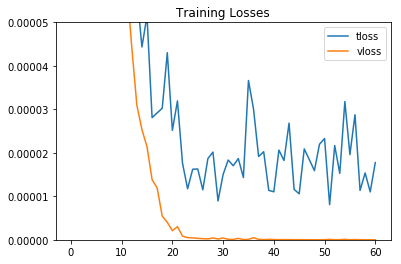

In [3]:
data11 = np.load('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runA.npz')

tloss = data11['tloss']
tloss_mean = np.mean(tloss,axis=0)
tloss_std = np.std(tloss,axis=0)/tloss.shape[0]

vloss = data11['vloss']
vloss_mean = np.mean(vloss,axis=0)
vloss_std = np.std(vloss,axis=0)/vloss.shape[0]

figure()
title('Training Losses')
plot(tloss_mean,label='tloss')
plot(vloss_mean,label='vloss')
ylim(0,0.00005)
legend()
# looks like 45 again is fine

# Debug Memoize on Stability Runs

In [6]:
data11 = np.load('experiments/test2_modelgrusimple_mid-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/mem-runA0-epoch40.npz')
six.print_(data11.files)
mem_arrays = data11['mem_arrays']
six.print_(mem_arrays[0])
six.print_(mem_arrays[1])
six.print_(mem_arrays[5][1000])

['mem_arrays']
[[ 0.  0.  0.  0.]]
[[  9.99760926e-01   3.76824639e-03   8.07295844e-04   9.57022654e-04]
 [  9.99999642e-01   1.92387219e-04   1.35941254e-05   2.43485943e-06]
 [  9.99998569e-01   2.81491225e-06   1.97608519e-04   1.10886810e-06]
 [  9.99971271e-01   1.81344876e-05   1.97847603e-05   5.24370116e-05]
 [  9.99985337e-01   1.15873900e-05   2.18772057e-05   1.53569781e-05]
 [  9.99988198e-01   8.85017812e-02   7.98502413e-04   1.37441570e-03]
 [  9.99203026e-01   2.60969537e-04   4.24301326e-02   1.45776814e-03]
 [  9.99477923e-01   7.42685515e-04   2.93014711e-03   2.23981193e-03]]
[  9.99999881e-01   9.99945760e-01   6.82999162e-05   2.55893869e-03]


# No Noise

50
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.  1.
  0.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
10
[ 0.  0.  0.  0.  0.  1.  0.  0.  1.  1.]
[ 0.01746425  0.07986125  0.05695659  0.04330979  0.03550459  0.05063539
  0.05656221  0.07760082  0.08905589  0.07502939]
vloss shape (50, 26)


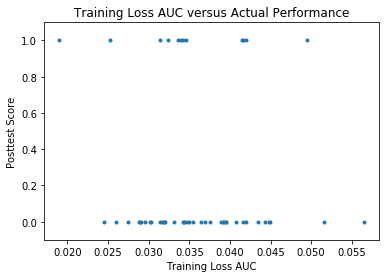

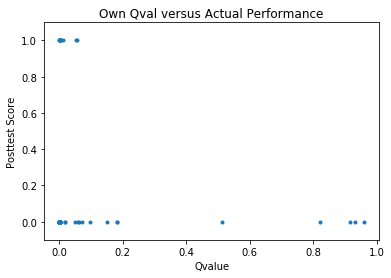

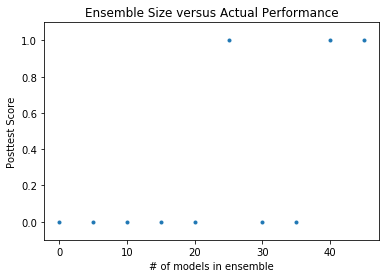

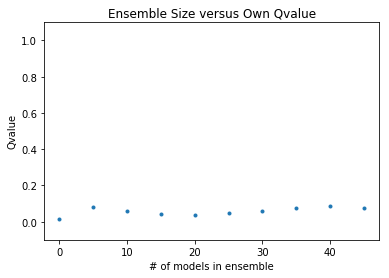

In [6]:
data11 = np.load('experiments/test2_modelgrusimple_mid-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runB.npz')
data21 = np.load('experiments/test2_modelgrusimple_mid-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/mcts-rtype2-rollouts10000-trajectories8-real1-runB.npz')
data31 = np.load('experiments/test2_modelgrusimple_mid-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/mcts-rtype2-rollouts10000-trajectories8-real0-runB.npz')

with open('experiments/test2_modelgrusimple_mid-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/fsearch-runB-horizon6.pickle','rb') as f:
    fsdata = pickle.load(f)

with open('experiments/test2_modelgrusimple_mid-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/fsearchensemble-runB-horizon6.pickle','rb') as f:
    fsensemble = pickle.load(f)

six.print_(len(fsdata))
fs_sq = np.array([d[0][1] for d in fsdata])
fs_sim_sq = np.array([d[0][3] for d in fsdata])
six.print_(fs_sim_sq)

six.print_(len(fsensemble))
fsen_sq = np.array([d[0][1] for d in fsensemble])
fsen_sim_sq = np.array([d[0][3] for d in fsensemble])
six.print_(fsen_sim_sq)
six.print_(fsen_sq)

vloss = np.vstack((data11['vloss'],))
vloss_auc = np.sum(vloss,axis=1)
vloss_last = np.mean(vloss[:,-2:],axis=1)

tloss = np.vstack((data11['tloss'],))
tloss_auc = np.sum(tloss,axis=1)
tloss_last = np.mean(tloss[:,-2:],axis=1)

#scores = np.vstack((data21['scores'],))[:,0]
#realqvals = np.vstack((data21['qvals'],))[:,0]
#selfqvals = np.vstack((data31['qvals'],))[:,0]

# ixs sorted by various things
#sorted_by_score = np.flipud(np.argsort(scores))
#ranked_by_score = ixs2ranks(sorted_by_score)

sorted_by_fs_sim_sq = np.flipud(np.argsort(fs_sim_sq))
ranked_by_fs_sim_sq = ixs2ranks(sorted_by_fs_sim_sq)

sorted_by_fs_sq = np.flipud(np.argsort(fs_sq))
ranked_by_fs_sq = ixs2ranks(sorted_by_fs_sq)

sorted_by_vloss = np.argsort(vloss_auc)
ranked_by_vloss = ixs2ranks(sorted_by_vloss)

#sorted_by_qval = np.flipud(np.argsort(selfqvals))
#ranked_by_qval = ixs2ranks(sorted_by_qval)

six.print_('vloss shape {}'.format(vloss.shape))

num_models = vloss_auc.shape[0]

graph_trainauc_score(vloss, fs_sim_sq)
ylim(-0.1,1.1)
# 12/50 good policy-models


graph_qval_score(fs_sq, fs_sim_sq)
ylim(-0.1,1.1)

graph_ensemble(fsen_sq, fsen_sim_sq)

In [21]:
for i in six.moves.range(num_models):
    ix = sorted_by_fs_sq[i]
    six.print_('{:2d} | fs sim sq {:.1f} {:2d}th | vloss auc {:.5f} {:2d}th | fs sq {:.4f} {:2d}th'.format(
        ix, fs_sim_sq[ix], ranked_by_fs_sim_sq[ix], vloss_auc[ix], ranked_by_vloss[ix], fs_sq[ix], ranked_by_fs_sq[ix]))

48 | fs sim sq 0.0 40th | vloss auc 0.04276 41th | fs sq 0.6436  0th
27 | fs sim sq 1.0  3th | vloss auc 0.03269 18th | fs sq 0.4515  1th
23 | fs sim sq 1.0  2th | vloss auc 0.03911 32th | fs sq 0.2222  2th
39 | fs sim sq 0.0 38th | vloss auc 0.03171 15th | fs sq 0.2149  3th
38 | fs sim sq 1.0  7th | vloss auc 0.04138 40th | fs sq 0.0738  4th
41 | fs sim sq 1.0  4th | vloss auc 0.03703 27th | fs sq 0.0609  5th
14 | fs sim sq 0.0 14th | vloss auc 0.03878 30th | fs sq 0.0238  6th
22 | fs sim sq 0.0 29th | vloss auc 0.02849  2th | fs sq 0.0167  7th
12 | fs sim sq 1.0  1th | vloss auc 0.04350 43th | fs sq 0.0143  8th
11 | fs sim sq 0.0 17th | vloss auc 0.04484 44th | fs sq 0.0135  9th
 5 | fs sim sq 0.0 22th | vloss auc 0.02810  1th | fs sq 0.0021 10th
32 | fs sim sq 1.0  9th | vloss auc 0.02874  5th | fs sq 0.0014 11th
21 | fs sim sq 0.0 18th | vloss auc 0.03332 19th | fs sq 0.0013 12th
47 | fs sim sq 0.0 31th | vloss auc 0.04067 39th | fs sq 0.0008 13th
24 | fs sim sq 0.0 28th | vloss au

# Noise 0.05

50
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
10
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 0.00221919  0.00588134  0.04776489  0.03156376  0.02851355  0.03003708
  0.02489186  0.02644758  0.02472523  0.02744734]
vloss shape (50, 46)


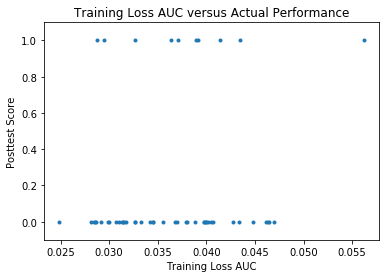

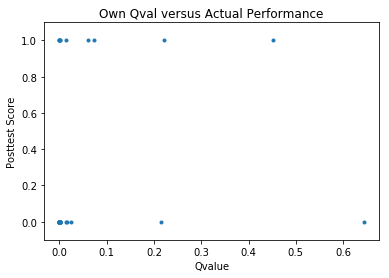

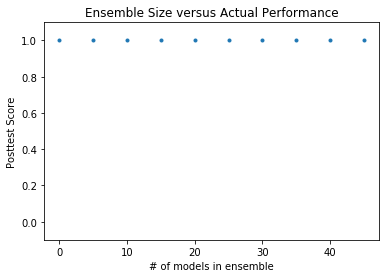

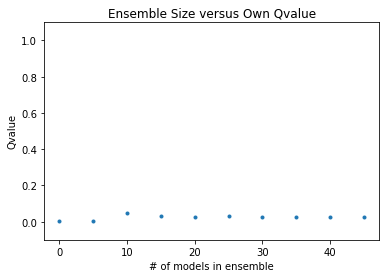

In [8]:
data11 = np.load('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runB.npz')
data21 = np.load('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/mcts-rtype2-rollouts10000-trajectories8-real1-runB.npz')
data31 = np.load('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/mcts-rtype2-rollouts10000-trajectories8-real0-runB.npz')

with open('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/fsearch-runB-horizon6.pickle','rb') as f:
    fsdata = pickle.load(f)
with open('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/fsearchensemble-runB-horizon6.pickle','rb') as f:
    fsensemble = pickle.load(f)

six.print_(len(fsdata))
fs_sq = np.array([d[0][1] for d in fsdata])
fs_sim_sq = np.array([d[0][3] for d in fsdata])
six.print_(fs_sim_sq)

six.print_(len(fsensemble))
fsen_sq = np.array([d[0][1] for d in fsensemble])
fsen_sim_sq = np.array([d[0][3] for d in fsensemble])
six.print_(fsen_sim_sq)
six.print_(fsen_sq)

vloss = np.vstack((data11['vloss'],))
vloss_auc = np.sum(vloss,axis=1)
vloss_last = np.mean(vloss[:,-2:],axis=1)

tloss = np.vstack((data11['tloss'],))
tloss_auc = np.sum(tloss,axis=1)
tloss_last = np.mean(tloss[:,-2:],axis=1)

#scores = np.vstack((data21['scores'],))[:,0]
#realqvals = np.vstack((data21['qvals'],))[:,0]
#selfqvals = np.vstack((data31['qvals'],))[:,0]

# ixs sorted by various things
#sorted_by_score = np.flipud(np.argsort(scores))
#ranked_by_score = ixs2ranks(sorted_by_score)

sorted_by_fs_sim_sq = np.flipud(np.argsort(fs_sim_sq))
ranked_by_fs_sim_sq = ixs2ranks(sorted_by_fs_sim_sq)

sorted_by_fs_sq = np.flipud(np.argsort(fs_sq))
ranked_by_fs_sq = ixs2ranks(sorted_by_fs_sq)

sorted_by_vloss = np.argsort(vloss_auc)
ranked_by_vloss = ixs2ranks(sorted_by_vloss)

#sorted_by_qval = np.flipud(np.argsort(selfqvals))
#ranked_by_qval = ixs2ranks(sorted_by_qval)

six.print_('vloss shape {}'.format(vloss.shape))

num_models = vloss_auc.shape[0]

graph_trainauc_score(vloss, fs_sim_sq)
ylim(-0.1,1.1)
# 10/50 good policy-models


graph_qval_score(fs_sq, fs_sim_sq)
ylim(-0.1,1.1)

#graph_qval_score(fsen_sq, fsen_sim_sq)
#ylim(-0.1,1.1)

graph_ensemble(fsen_sq, fsen_sim_sq)

In [22]:
for i in six.moves.range(num_models):
    ix = sorted_by_fs_sq[i]
    six.print_('{:2d} | fs sim sq {:.1f} {:2d}th | vloss auc {:.5f} {:2d}th | fs sq {:.4f} {:2d}th'.format(
        ix, fs_sim_sq[ix], ranked_by_fs_sim_sq[ix], vloss_auc[ix], ranked_by_vloss[ix], fs_sq[ix], ranked_by_fs_sq[ix]))

48 | fs sim sq 0.0 40th | vloss auc 0.04276 41th | fs sq 0.6436  0th
27 | fs sim sq 1.0  3th | vloss auc 0.03269 18th | fs sq 0.4515  1th
23 | fs sim sq 1.0  2th | vloss auc 0.03911 32th | fs sq 0.2222  2th
39 | fs sim sq 0.0 38th | vloss auc 0.03171 15th | fs sq 0.2149  3th
38 | fs sim sq 1.0  7th | vloss auc 0.04138 40th | fs sq 0.0738  4th
41 | fs sim sq 1.0  4th | vloss auc 0.03703 27th | fs sq 0.0609  5th
14 | fs sim sq 0.0 14th | vloss auc 0.03878 30th | fs sq 0.0238  6th
22 | fs sim sq 0.0 29th | vloss auc 0.02849  2th | fs sq 0.0167  7th
12 | fs sim sq 1.0  1th | vloss auc 0.04350 43th | fs sq 0.0143  8th
11 | fs sim sq 0.0 17th | vloss auc 0.04484 44th | fs sq 0.0135  9th
 5 | fs sim sq 0.0 22th | vloss auc 0.02810  1th | fs sq 0.0021 10th
32 | fs sim sq 1.0  9th | vloss auc 0.02874  5th | fs sq 0.0014 11th
21 | fs sim sq 0.0 18th | vloss auc 0.03332 19th | fs sq 0.0013 12th
47 | fs sim sq 0.0 31th | vloss auc 0.04067 39th | fs sq 0.0008 13th
24 | fs sim sq 0.0 28th | vloss au

# Output Dropout 0.5

50
[ 0.  0.  1.  0.  0.  1.  1.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.  1.  0.
  1.  0.  1.  1.  1.  0.  0.  0.  0.  1.  1.  0.  0.  0.]
10
[ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 0.0659767   0.16910166  0.20429283  0.18863686  0.18375941  0.17043165
  0.14426911  0.13284281  0.1172225   0.11215429]
vloss shape (50, 26)


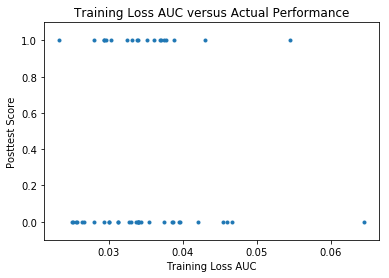

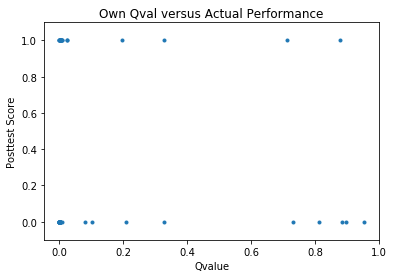

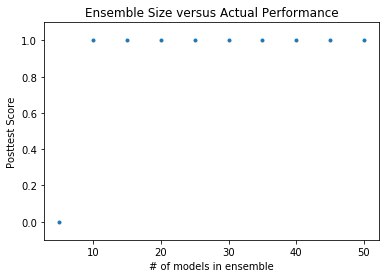

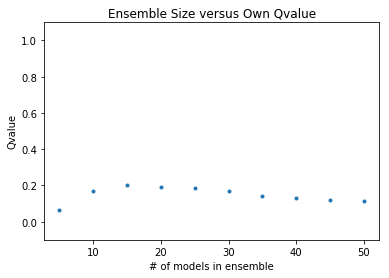

In [5]:
data11 = np.load('experiments/test2_modelgrusimple_mid-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runB.npz')

with open('experiments/test2_modelgrusimple_mid-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle/fsearch-runB-horizon6.pickle','rb') as f:
    fsdata = pickle.load(f)

with open('experiments/test2_modelgrusimple_mid-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle/fsearchensemble-runB-horizon6.pickle','rb') as f:
    fsensemble = pickle.load(f)

six.print_(len(fsdata))
fs_sq = np.array([d[0][1] for d in fsdata])
fs_sim_sq = np.array([d[0][3] for d in fsdata])
six.print_(fs_sim_sq)

six.print_(len(fsensemble))
fsen_sq = np.array([d[0][1] for d in fsensemble])
fsen_sim_sq = np.array([d[0][3] for d in fsensemble])
six.print_(fsen_sim_sq)
six.print_(fsen_sq)

vloss = np.vstack((data11['vloss'],))
vloss_auc = np.sum(vloss,axis=1)
vloss_last = np.mean(vloss[:,-2:],axis=1)

tloss = np.vstack((data11['tloss'],))
tloss_auc = np.sum(tloss,axis=1)
tloss_last = np.mean(tloss[:,-2:],axis=1)

sorted_by_fs_sim_sq = np.flipud(np.argsort(fs_sim_sq))
ranked_by_fs_sim_sq = ixs2ranks(sorted_by_fs_sim_sq)

sorted_by_fs_sq = np.flipud(np.argsort(fs_sq))
ranked_by_fs_sq = ixs2ranks(sorted_by_fs_sq)

sorted_by_vloss = np.argsort(vloss_auc)
ranked_by_vloss = ixs2ranks(sorted_by_vloss)

six.print_('vloss shape {}'.format(vloss.shape))

num_models = vloss_auc.shape[0]

graph_trainauc_score(vloss, fs_sim_sq)
ylim(-0.1,1.1)
# 19/50 good policy-models


graph_qval_score(fs_sq, fs_sim_sq)
ylim(-0.1,1.1)

graph_ensemble(fsen_sq, fsen_sim_sq)

# Output Dropout 0.5 Noise 0.05

50
[ 1.  0.  0.  0.  1.  0.  1.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  1.  0.  1.  1.  0.  0.  1.  1.  0.  0.  0.
  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
10
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 0.04315014  0.07911268  0.0513794   0.03714532  0.03305226  0.02994393
  0.02725679  0.02780373  0.02482705  0.02263558]
vloss shape (50, 46)


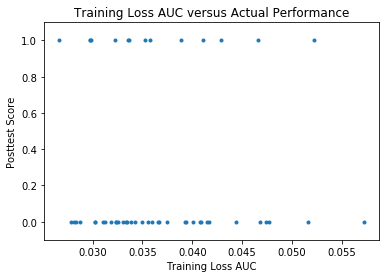

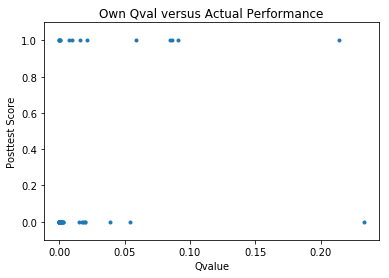

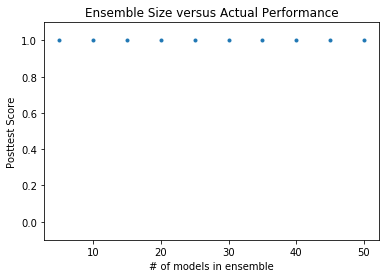

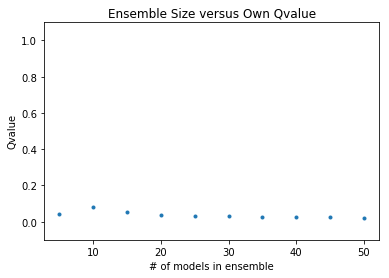

In [6]:
data11 = np.load('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runB.npz')

with open('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle/fsearch-runB-horizon6.pickle','rb') as f:
    fsdata = pickle.load(f)

with open('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle/fsearchensemble-runB-horizon6.pickle','rb') as f:
    fsensemble = pickle.load(f)

six.print_(len(fsdata))
fs_sq = np.array([d[0][1] for d in fsdata])
fs_sim_sq = np.array([d[0][3] for d in fsdata])
six.print_(fs_sim_sq)

six.print_(len(fsensemble))
fsen_sq = np.array([d[0][1] for d in fsensemble])
fsen_sim_sq = np.array([d[0][3] for d in fsensemble])
six.print_(fsen_sim_sq)
six.print_(fsen_sq)

vloss = np.vstack((data11['vloss'],))
vloss_auc = np.sum(vloss,axis=1)
vloss_last = np.mean(vloss[:,-2:],axis=1)

tloss = np.vstack((data11['tloss'],))
tloss_auc = np.sum(tloss,axis=1)
tloss_last = np.mean(tloss[:,-2:],axis=1)

sorted_by_fs_sim_sq = np.flipud(np.argsort(fs_sim_sq))
ranked_by_fs_sim_sq = ixs2ranks(sorted_by_fs_sim_sq)

sorted_by_fs_sq = np.flipud(np.argsort(fs_sq))
ranked_by_fs_sq = ixs2ranks(sorted_by_fs_sq)

sorted_by_vloss = np.argsort(vloss_auc)
ranked_by_vloss = ixs2ranks(sorted_by_vloss)

six.print_('vloss shape {}'.format(vloss.shape))

num_models = vloss_auc.shape[0]

graph_trainauc_score(vloss, fs_sim_sq)
ylim(-0.1,1.1)
# 14/50 good policy-models


graph_qval_score(fs_sq, fs_sim_sq)
ylim(-0.1,1.1)

graph_ensemble(fsen_sq, fsen_sim_sq)